# Generate the gouge event catalog

Generate the gouge event catalog for the analysis of the gouge event stats.

2025.01.04 Kurama Okubo

- 2025.01.28 update to include the std on M0 and Tw.

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings
import time
import pickle 
import seaborn as sns
import copy

%load_ext autoreload
%autoreload 2

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = False #True


# Read the data sheet

We load the gouge event data from `Experiments/DetectEvent/data/p06_visual_pick_gougeevents_merged.csv`, `SourceInvFit/data/datacsv/AE_obs_location.csv`, `GougeEventStats/Mainshocktiming/data/MainshockTiming_FB03_087.csv` and `ComputeScaling/data/05_STFstats/SourceParam_meanstd_fb03-087_G3_wlv_0.30_denoisemethod_detrend.csv`.

We collect the following quantities:

1. Event ID
2. location
3. event onset time
4. stick-slip ID
5. foreshock/aftershock label
6. Q correction quartile
7. event magnitude (mean by four AE sensors)
8. moment magnitude (mean by four AE sensors)
9. source duration (mean by four AE sensors)


In [2]:
# 1. Read the csv pick datasheet
expr_id= 87 # casename of experiment
fi_catalog="../../Experiments/DetectEvent/data/p06_visual_pick_gougeevents_merged.csv"
columns = ["expr_id", "event_id", "event_loc", "picktime", "event_type", "rupturetype", "gougeevent_id", "doublecheck", "old_gougeevent_id"]
df_catalog = pd.read_csv(fi_catalog, skiprows=5, names=columns)
df_expr = df_catalog[(df_catalog["expr_id"]==f"fb03-{expr_id:03d}")]
df_expr.head()

,expr_id,event_id,event_loc,picktime,event_type,rupturetype,gougeevent_id,doublecheck,old_gougeevent_id
0,fb03-087,2,2.75,41.02500,LFE,2,0,1,0
1,fb03-087,3,1.25,42.46400,LFE,1,1,1,1
2,fb03-087,3,1.25,42.46450,Ordinary,1,2,1,2
3,fb03-087,3,3.25,42.46790,Ordinary,1,3,1,212
4,fb03-087,3,1.75,42.47475,Ordinary,1,4,1,3


In [3]:
# 2. Read relocation stats 
eventloc_table = "../../SourceInvFit/data/datacsv/AE_obs_location.csv"
df_eventloc = pd.read_csv(eventloc_table, index_col=0)
df_eventloc.head()

,stickslip_id,exprID,origin_time,X,Y,V,Vs,dx_best,dy_best
gougeevent_id,,,,,,,,,
4,3,fb03-087,42.474772,1.7475,0.00505,6200,3600,0.0,-0.0002
9,5,fb03-087,47.662693,1.7425,0.00375,6200,3600,0.0,0.0000
18,8,fb03-087,56.727044,1.7460,0.00375,6200,3600,0.0,0.0000
19,9,fb03-087,59.103175,1.7425,0.00300,6200,3600,0.0,0.0000
20,9,fb03-087,59.103526,1.7460,0.00325,6200,3600,0.0,0.0010


In [4]:
# We analyzed the patch G3
eventids = df_eventloc.index.values
len(eventids)

44

In [5]:
# 3. Read the source parameters
gougepatch_id = "G3" # to set output filename
gougepatch_x = 1.75 # location of G3
denoise_method = "detrend"
Qinv_quart = 50
k_waterlevel = 0.3

In [6]:
foname_mean = f"../../ComputeScaling/data/05_STFstats/SourceParam_meanstd_fb03-{expr_id:03d}_{gougepatch_id}_wlv_{k_waterlevel:.2f}_denoisemethod_{denoise_method.lower()}.csv"

df_stats = pd.read_csv(foname_mean, index_col=0)
df_stats_case = df_stats[df_stats["Qinv_quart"] == f"{Qinv_quart}"]
df_stats_case_sorted = df_stats_case.sort_values(by="M0_mean", ascending=False)
print(df_stats_case_sorted.shape)
df_stats_case_sorted.head()


(44, 8)


,datacase,gougeevent_id,Qinv_quart,Nvalidsensors,M0_mean,M0_std,Tw_mean,Tw_std
index,,,,,,,,
fb03-087,fb03-087__0088,88,50,4,1.258743,0.645682,0.000002,2.308593e-07
fb03-087,fb03-087__0129,129,50,4,1.134119,0.407475,0.000003,1.733592e-07
fb03-087,fb03-087__0031,31,50,4,0.974691,0.262768,0.000003,2.155345e-07
fb03-087,fb03-087__0095,95,50,4,0.912162,0.267969,0.000003,1.184915e-07
fb03-087,fb03-087__0020,20,50,4,0.867075,0.209970,0.000003,1.379112e-07


# Read the mainshock timing

In [7]:
fi_mainshocktiming = "../../GougeEventStats/Mainshocktiming/data/MainshockTiming_FB03_087.csv"

df_mainshock = pd.read_csv(fi_mainshocktiming, index_col=0)
df_mainshock.head()

,mainshock_onset_all,mainshock_termination_all,mainshock_duration_all
Stickslip_eventID,,,
1,36.683550,36.720155,0.036605
2,41.028781,41.043626,0.014845
3,42.465061,42.479129,0.014068
4,43.624988,43.638608,0.013620
5,47.665642,47.699931,0.034289


## Evaluate the foreshock/aftershock event label

In [8]:
df_eventlabel = pd.DataFrame(columns=["event_id", "event_label"])
for eid in eventids:
# eid = eventids[10]
    # print(eid)
    
    eventtime = df_eventloc.loc[eid, :].origin_time
    stickslip_id = df_eventloc.loc[eid, :].stickslip_id
    mainshock_timing = df_mainshock.loc[stickslip_id, "mainshock_onset_all"]
    
    if eventtime<mainshock_timing:
        event_label = "F" #F: foreshock, A: aftershock
    else:
        event_label = "A" #F: foreshock, A: aftershock
    
    # print(eventtime, stickslip_id, mainshock_timing, event_label)
    data = {"event_id": [eid],
           "event_label": [event_label]}
    
    df_eventlabel = pd.concat([df_eventlabel, pd.DataFrame.from_dict(data)])
    
df_eventlabel = df_eventlabel.set_index("event_id")

In [9]:
# Aftershock list visually detected to double check the label
# Note that this reference includes the events on the all gouge patches
ref_aftershock_ids = [3,4,7,15,16,17,32,33,43,46,51,52,56,57,62,63,67,68,69,76,77,80,87,89,
                  90,92,93,100,102,103,104,105,106,107,108,109,111,114,116,118,120,123,124,128,132]; # we visually categorized the aftershocks.


In [10]:
for index, row in df_eventlabel.iterrows():
    if index in ref_aftershock_ids:
        # check if this is labeled as aftershock
        assert(row.event_label == "A")
    else:
        # check if this is labeled as foreshock
        assert(row.event_label == "F")

In [11]:
Nforeshock = len(df_eventlabel[df_eventlabel["event_label"]=="F"])
Naftershock = len(df_eventlabel[df_eventlabel["event_label"]=="A"])

print(f"Number of foreshock: {Nforeshock} aftershock {Naftershock} total {Nforeshock+Naftershock}")

Number of foreshock: 29 aftershock 15 total 44


# Compile the catalog


1. Event ID
2. location
3. event onset time
4. stick-slip ID
5. foreshock/aftershock label
6. Q correction quartile
7. event magnitude (mean by four AE sensors)
8. moment magnitude (mean by four AE sensors)
9. source duration (mean by four AE sensors)


In [12]:
def M02Mw(M0):
    return (np.log10(M0) - 9.1) * 2.0 / 3.0 # synchronized with OpenSWPC : moment_magnitude ( m0 )

def Mw2M0(Mw):
    return 10**( 1.5 * Mw + 9.05) # synchronized with OpenSWPC : seismic_moment ( mw )
   

In [13]:
catalog_columns = ["event_id", "location", "event_onset_time", "stickslip_id", "event_label", "Q_correction_quart", "Nvalidsensors", "M0", "Mw", "Tw"]
df_event_master= pd.DataFrame(columns=catalog_columns)
for eid in eventids: 
    # eid = eventids[10]
    # print(eid)
    
    eventtime = df_eventloc.loc[eid, "origin_time"]
    stickslip_id = df_eventloc.loc[eid, "stickslip_id"]
    event_label = df_eventlabel.loc[eid, "event_label"]
    Nvalidsensors = df_stats_case_sorted[df_stats_case_sorted["gougeevent_id"]==eid].Nvalidsensors.values[0]
    M0_mean = df_stats_case_sorted[df_stats_case_sorted["gougeevent_id"]==eid].M0_mean.values[0]
    M0_std = df_stats_case_sorted[df_stats_case_sorted["gougeevent_id"]==eid].M0_std.values[0]
    Mw_mean = M02Mw(M0_mean)
    Tw_mean = df_stats_case_sorted[df_stats_case_sorted["gougeevent_id"]==eid].Tw_mean.values[0]
    Tw_std = df_stats_case_sorted[df_stats_case_sorted["gougeevent_id"]==eid].Tw_std.values[0]

    data = {"event_id": [eid],
            "location": [gougepatch_x],
            "event_onset_time": [eventtime],
            "stickslip_id": [stickslip_id],
            "event_label": [event_label],
            "Q_correction_quart": [Qinv_quart],
            "Nvalidsensors": [Nvalidsensors],
            "M0": [M0_mean],
            "M0_std": [M0_std],
            "Mw": [Mw_mean],
            "Tw": [Tw_mean],
            "Tw_std": [Tw_std],}

    if not df_event_master.empty:
        df_event_master = pd.concat([df_event_master, pd.DataFrame.from_dict(data)])
    else:
        df_event_master = pd.DataFrame.from_dict(data)
    
df_event_master = df_event_master.set_index("event_id")

In [14]:
df_event_master

,location,event_onset_time,stickslip_id,event_label,Q_correction_quart,Nvalidsensors,M0,M0_std,Mw,Tw,Tw_std
event_id,,,,,,,,,,,
4,1.75,42.474772,3,A,50,4,0.594031,0.179160,-6.217461,0.000003,1.516442e-07
9,1.75,47.662693,5,F,50,4,0.047135,0.007497,-6.951102,0.000002,3.630314e-07
18,1.75,56.727044,8,F,50,4,0.757592,0.193624,-6.147043,0.000003,3.109912e-07
19,1.75,59.103175,9,F,50,4,0.056071,0.017249,-6.900839,0.000002,2.699614e-07
20,1.75,59.103526,9,F,50,4,0.867075,0.209970,-6.107962,0.000003,1.379112e-07
21,1.75,63.752300,10,F,50,4,0.021673,0.003116,-7.176053,0.000002,2.064907e-07
24,1.75,66.186944,11,F,50,4,0.065804,0.021153,-6.854498,0.000002,2.825796e-07
27,1.75,76.018478,14,F,50,4,0.763685,0.210829,-6.144724,0.000003,2.019305e-07
30,1.75,79.319850,15,F,50,2,0.051639,0.010459,-6.924681,0.000003,2.346797e-07


<Axes: xlabel='event_onset_time', ylabel='Tw'>

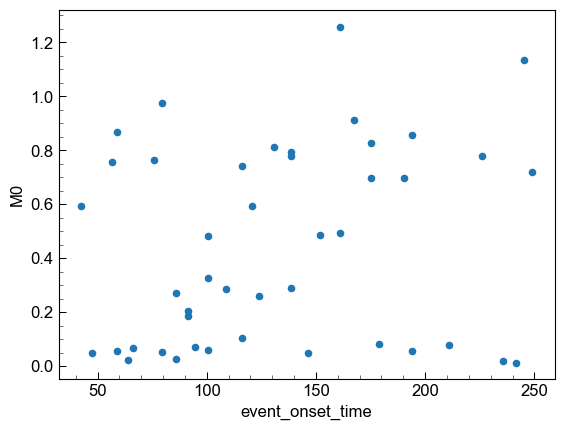

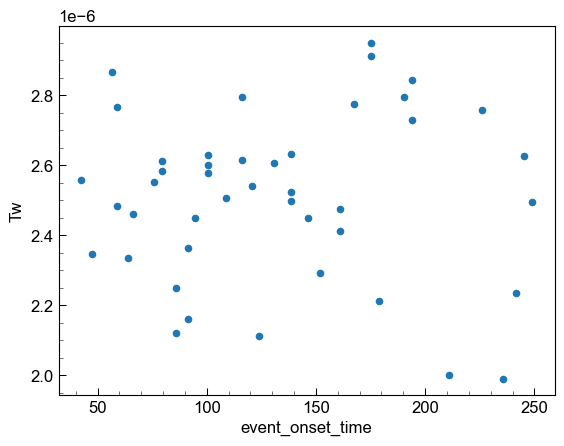

In [15]:
df_event_master.plot.scatter(x="event_onset_time", y="M0")
df_event_master.plot.scatter(x="event_onset_time", y="Tw")

In [16]:
len(df_event_master)

44

In [17]:
# Dump the dataframe
df_event_master.to_csv(f"../data/gougeeventcatalog__fb03-{expr_id:03d}__{gougepatch_id}__Q{Qinv_quart}.csv", float_format="%12.8g")